<a href="https://colab.research.google.com/github/MacApos/Google-Colab/blob/main/Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import bibliotek

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
from keras import Model
from keras import applications
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras_preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

# Wczytywanie danych

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%bash
unzip '/content/drive/My Drive/dogs-vs-cats.zip' -d '/content'

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train

unzip -q /content/test1.zip

In [ ]:
%%bash
rm -rf test1.zip
rm -rf sampleSubmission.csv
rm -rf test1
rm -rf data
rm -rf bottleneck_features_train.npy
rm -rf bottleneck_features_validation.npy
# rm -rf kaggle_original_data

In [ ]:
original_dataset_dir = '/content/kaggle_original_data'
base_dir = '/content/data'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

for directory in (train_dir, validation_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_dir_cats = os.path.join(train_dir, 'cats')
train_dir_dogs = os.path.join(train_dir, 'dogs')

validation_dir_cats = os.path.join(validation_dir, 'cats')
validation_dir_dogs = os.path.join(validation_dir, 'dogs')

dirs = [train_dir_cats, train_dir_dogs, validation_dir_cats, validation_dir_dogs]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [ ]:
# Cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir_cats, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir_cats, fname)
    shutil.copyfile(src, dst)

# Dogs
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dir_dogs, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1400)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dir_dogs, fname)
    shutil.copyfile(src, dst)

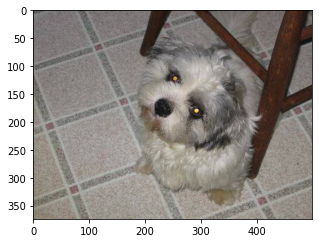

In [ ]:
def img_load(animal, index):
    if animal == 'cat':
        img_path = train_dir_cats + '/' + 'cat.' + str(index) + '.jpg'
    elif animal == 'dog':
        img_path = train_dir_dogs + '/' + 'dog.' + str(index) + '.jpg'
    img = image.load_img(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.grid(False)
    plt.show()

img_load('dog', 78)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

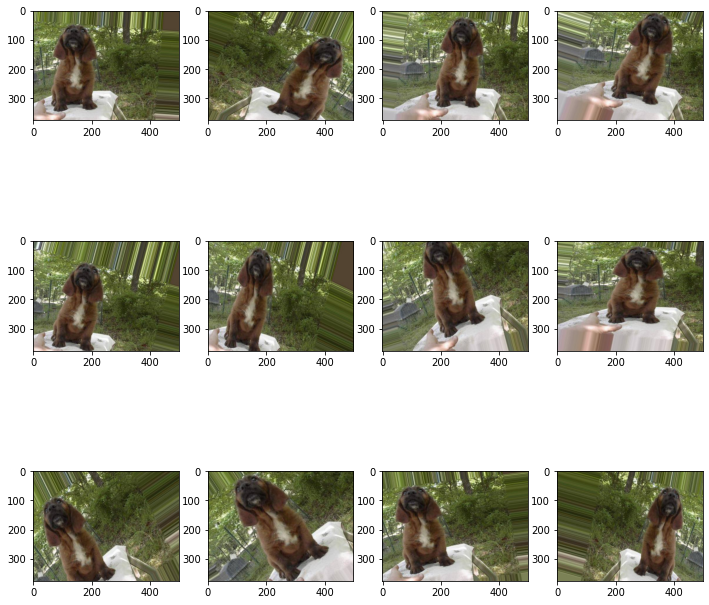

In [ ]:
def display_augmented_data(animal, index):
    if animal == 'cat':
        img = load_img(train_dir_cats + '/' + 'cat.' + str(index) + '.jpg')
    elif animal == 'dog':
        img = load_img(train_dir_dogs + '/' + 'dog.' + str(index) + '.jpg')
    preview = os.path.join(base_dir, 'preview')
    if os.path.exists(preview):
        shutil.rmtree(preview)
    os.mkdir(preview)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=preview, save_prefix=animal, save_format='jpg'):
         i += 1
         if i % 12 == 0:
             break
    fig = plt.figure(figsize=(12, 12))
    for idx, val in enumerate(os.listdir(preview)):
        img = image.load_img(os.path.join(preview, val))
        y = fig.add_subplot(3, 4, idx+1)
        plt.grid(False)
        y.imshow(img)
    plt.show()


display_augmented_data('dog', 5)

# Original

In [ ]:
img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = validation_dir
nb_train_samples = 2000
nb_validation_samples = 800
n_epochs = 30
batch_size = 16

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_generator = datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

validation_generator = datagen.flow_from_directory(validation_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs = n_epochs,
                    validation_data=validation_generator,
                    validation_steps = nb_validation_samples // batch_size)
model.save_weights('first_try.h5')

In [ ]:
def make_accuracy_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], 
                             name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], 
                             name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=800, height=500, title='Accuracy vs. Val Accuracy', 
                      xaxis_title='Epoki', yaxis_title='Accuracy')
    fig.show()

In [ ]:
def make_loss_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epochs'] = history.epoch
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epochs'], y=hist['loss'], name='loss', 
                             mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epochs'], y=hist['val_loss'], 
                              name='val_loss', mode='markers+lines'))
    fig.update_layout(width=800, height=500, title='Loss vs. Val Loss', xaxis_title=
                      'Epochs', yaxis_title='Loss')

    fig.show()

# Bottleneck

In [ ]:
img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = validation_dir
nb_train_samples = 2000
nb_validation_samples = 800
n_epochs = 30
batch_size = 16

In [ ]:
# def save_bottleneck_features():
datagen = ImageDataGenerator(rescale=1./255.)
model=applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(train_data_dir,
                                        target_size=(img_width, img_height),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)
bottleneck_features_train = model.predict(generator, 
                                          nb_train_samples // batch_size)
with open('bottleneck_features_train.npy', 'wb') as save_feature_train_file:
  np.save(save_feature_train_file, bottleneck_features_train)

generator = datagen.flow_from_directory(validation_data_dir,
                                      target_size=(img_width, img_height),
                                      batch_size=batch_size,
                                      class_mode=None,
                                      shuffle=False)
bottleneck_features_validation = model.predict(generator, 
                                        nb_validation_samples // batch_size)
with open('bottleneck_features_validation.npy', 'wb') as save_feature_validation_file:
  np.save(save_feature_validation_file, bottleneck_features_validation)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
# save_bottleneck_features

In [ ]:
with open('bottleneck_features_train.npy', 'rb') as load_feature_train_file:
  train_data = np.load(load_feature_train_file)
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

with open('bottleneck_features_validation.npy', 'rb') as load_feature_validation_file:
  validation_data = np.load(load_feature_validation_file)
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, train_labels,
          epochs=50,
          batch_size = batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.6245 - accuracy: 0.7530 - val_loss: 0.4469 - val_accuracy: 0.7837
Epoch 2/50
125/125 [==============================] - 0s 4ms/step - loss: 0.3438 - accuracy: 0.8570 - val_loss: 0.2451 - val_accuracy: 0.8975
Epoch 3/50
125/125 [==============================] - 1s 6ms/step - loss: 0.2784 - accuracy: 0.8870 - val_loss: 0.2911 - val_accuracy: 0.8788
Epoch 4/50
125/125 [==============================] - 0s 4ms/step - loss: 0.2394 - accuracy: 0.9040 - val_loss: 0.2748 - val_accuracy: 0.8950
Epoch 5/50
125/125 [==============================] - 0s 4ms/step - loss: 0.2116 - accuracy: 0.9090 - val_loss: 0.3982 - val_accuracy: 0.8425
Epoch 6/50
125/125 [==============================] - 0s 4ms/step - loss: 0.1783 - accuracy: 0.9265 - val_loss: 0.2794 - val_accuracy: 0.9013
Epoch 7/50
125/125 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.9305 - val_loss: 0.3102 - val_accuracy: 0.8900
Epoch 

In [ ]:
make_accuracy_plot(history)

In [ ]:
make_loss_plot(history)

# Fine tune

In [ ]:
img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = validation_dir
nb_train_samples = 2000
nb_validation_samples = 800
n_epochs = 30
batch_size = 16

In [ ]:
base_model = applications.VGG16(weights='imagenet', include_top=False, 
                               input_shape=(img_width, img_height, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights('bottleneck_fc_model.h5')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

for layers in model.layers[25:]:
  layer.trainable = False

tensorflow.python.keras.callbacks.History

In [ ]:
model.compile(loss='binary_crossentropy',
                      optimizer=SGD(lr=1e-4, momentum=0.9),
                      metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

validation_generator = datagen.flow_from_directory(validation_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs=n_epochs, 
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples // batch_size)

Epoch 1/30
125/125 [==============================] - 17s 136ms/step - loss: 0.7459 - accuracy: 0.6295 - val_loss: 0.6196 - val_accuracy: 0.6162
Epoch 2/30
125/125 [==============================] - 17s 134ms/step - loss: 0.5292 - accuracy: 0.7420 - val_loss: 0.3922 - val_accuracy: 0.8238
Epoch 3/30
125/125 [==============================] - 17s 136ms/step - loss: 0.3800 - accuracy: 0.8280 - val_loss: 0.3065 - val_accuracy: 0.8712
Epoch 4/30
125/125 [==============================] - 17s 136ms/step - loss: 0.2343 - accuracy: 0.9045 - val_loss: 0.2985 - val_accuracy: 0.8900
Epoch 5/30
125/125 [==============================] - 17s 137ms/step - loss: 0.1358 - accuracy: 0.9495 - val_loss: 0.3281 - val_accuracy: 0.9062
Epoch 6/30
125/125 [==============================] - 17s 137ms/step - loss: 0.0665 - accuracy: 0.9760 - val_loss: 0.3541 - val_accuracy: 0.9062
Epoch 7/30
125/125 [==============================] - 17s 137ms/step - loss: 0.0234 - accuracy: 0.9910 - val_loss: 0.5213 - val_ac

In [ ]:
make_accuracy_plot(history)

In [ ]:
make_loss_plot(history)